# PDBe Tutorial - Malaria Case Study

This notenook is a tutorial to demonstarte how a researcher can use PDBe REST-API service (www.pdbe.org/api) to explore the information available in PDBe (www.pdbe.org). 


# Objective of this tutorial

This tutorial will show how to find out all PDB entries from a species (in this case from Plasmodium falciparum) and then how to filter the result to find out desired information. In this case, we are interested to find out all the hetgroups (that have molecular weight between 100-500) found in PDB entries from Plasmodium falciparum within a certain resolution and how many of those hetcodes are present in Drugbank and CCDC. 

## 1) Setup

### (Optional) Installing dependencies

You may need to install some of the libraries that this tutorial use. The easiest way is to type in:

pip3 install scipy

pip3 install pandas

pip3 install matplotlib

pip3 install requests

### Importing dependencies

It is good practise to do all imports at the beginning of the script

In [86]:
import json
import requests
import pandas as pd
import scipy
from functools import reduce
import matplotlib.pyplot as plt


%matplotlib inline

### Setting constants

In [87]:
# constants
SEARCH_URL = 'http://www.ebi.ac.uk/pdbe/search/pdb/select?q='
SEARCH_OPTIONS = '&wt=json&rows=100000'

### Helper functions

These functions will be used to run the search queries

In [88]:
def url_response(url):
    """
    Getting JSON response from URL
    :param url: String
    :return: JSON
    """
    r = requests.get(url=url)
    # Status code 200 means 'OK'
    if r.status_code == 200:
        json_result = r.json()
        return json_result
    else:
        print(r.status_code, r.reason)
        return None

def run_search(pdbe_search_term):
    """
    Running search with terms, for example 
    organism_synonyms:"Plasmodium"
    
    Check pdbe search api documentation for more detials
    :param pdbe_search_term: String
    :return: JSON
    """
    # This constructs the complete query URL
    full_query = SEARCH_URL + pdbe_search_term + SEARCH_OPTIONS

    response = url_response(full_query)
    if 'response' in response.keys() and 'docs' in response['response']:
        return response['response']['docs']
    else:
        return None

## 2) Searching

### Search for organism: Plasmodium

In [89]:
# Set the search term
search_terms_organism = 'organism_synonyms:"Plasmodium"'

# Perform search
results_organism = run_search(search_terms_organism)

### Find out how many species are there where plasmodium as synonyms

In [90]:
organism_list = []
all_organism_list = []
list_all_plasmodium_pdb = []
clean_all_organism_list = []
for result in results_organism:
    
    organism = result['organism_scientific_name']
    entry_id = result['pdb_id']
    list_all_plasmodium_pdb.append(entry_id)
    all_organism_list.append(organism)
    only_plasmodium = [x for x in organism if 'Plasmodium' in x]
    for b in only_plasmodium:
        clean_all_organism_list.append(b)
    
    
    if only_plasmodium not in organism_list:
        organism_list.append(only_plasmodium)

print('total number of PDB entires'+' '+str(len(list_all_plasmodium_pdb)))
print(len(clean_all_organism_list))


total number of PDB entires 1302
1302


### Finally we can save our dataset as csv file 

In [91]:
plasmodium_species_data = pd.DataFrame(list(zip(list_all_plasmodium_pdb, clean_all_organism_list)),
              columns=['entry','organism'])
plasmodium_species_data.head()

,entry,organism
0,5tpx,Plasmodium falciparum 3D7
1,3fr3,Plasmodium falciparum
2,2aqw,Plasmodium yoelii
3,4j4n,Plasmodium falciparum 3D7
4,1qs8,Plasmodium vivax


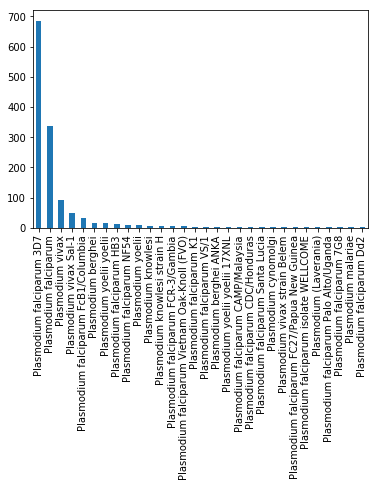

In [92]:
plasmodium_species_data['organism'].value_counts().plot(kind='bar')

### We will work with only Plasmodium falciparum

In [93]:
# Set search term
search_terms_plasmodium = 'organism_scientific_name:"Plasmodium%20falciparum"'

# Perform search
results_plasmodium = run_search(search_terms_plasmodium)

#print(results_plasmodium)#this is how the result docmument looks like

### Now create several list with the kind of data we want to extract

In [94]:
pdb_list = []  # gives list of pdb entry
high_res_pdb_list = [] #list of pdb entry with resolution <1.8A
pfam_list = []
comp_list = [] # list of all pdb hetcodes found 
comp_wt_list = []
r_free_list = []
molecule_name_list = [] # list of protein names
resolution_list = []

for pdbid in results_plasmodium:
    pdb = pdbid['pdb_id']
    pdb_list.append(pdb)
    resolutionid = pdbid['pivot_resolution']
    resolution_list.append(resolutionid)
    molecule_names = pdbid['all_molecule_names']
    molecule_name_list.append(molecule_names)
    
    
    try:
        rfree_entry = pdbid['r_free']
        r_free_list.append(rfree_entry)
    except:
        pass
  
    
    try:
        pfam = pdbid['pfam_name']
    except:
        pass
    if pfam not in pfam_list:
        pfam_list.append(pfam)

    
    if resolutionid < 1.8:
        high_res_pdb_list.append(pdb)
    try:
        comp = pdbid['compound_id']
        comp_wt = pdbid['compound_weight']
    except:
        pass
    
    if comp not in comp_list:
        comp_list.append(comp)
    if comp_wt not in comp_wt_list:
        comp_wt_list.append(comp_wt)
list_of_unique_pfam = reduce(lambda x,y:x+y, pfam_list)
list_of_comp = reduce(lambda x,y: x+y,comp_list)

list_of_mol_names = reduce(lambda x,y: x+y,molecule_name_list)
list_of_mol_wt_com = reduce(lambda x,y: x+y,comp_wt_list)
                

print('total number of PDB entires'+' '+str(len(pdb_list)))
print(str(len(high_res_pdb_list))+' '+'entries have resolution less than 1.8A')


total number of PDB entires 336
43 entries have resolution less than 1.8A


In [95]:
resolution_df = pd.DataFrame({'res':resolution_list})
resolution_df_corr = resolution_df[resolution_df['res'] < 10]# removes nmr entries that have resolution 1000 A as a space filler


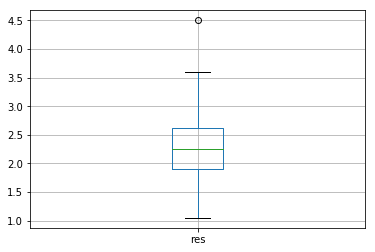

In [96]:
res_box_plot = resolution_df_corr.boxplot(column =['res']) #shows distribution of resolution in all entries

In [97]:
r_free_df = pd.DataFrame({'r_free':r_free_list})

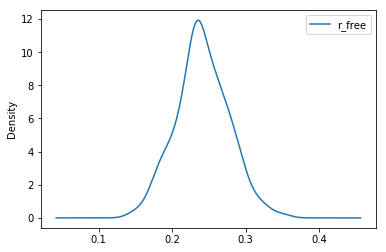

In [98]:
r_free_distribution = r_free_df.plot.kde() # shows distribution of rfree in all pdb entires

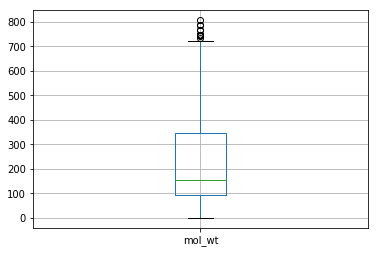

In [99]:
mol_wt_df = pd.DataFrame({'mol_wt':list_of_mol_wt_com})
mol_wt_box_plot = mol_wt_df.boxplot(column = ['mol_wt']) # distribution of molecular weight of all hetcodes found in these entrie

In [100]:
mol_wt_100_500 = mol_wt_df[(mol_wt_df['mol_wt'] < 500) & (mol_wt_df['mol_wt'] > 100)]

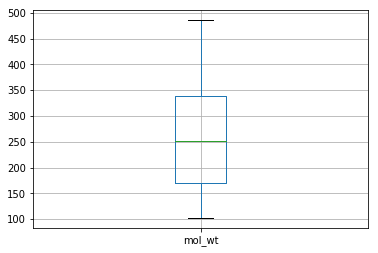

In [101]:
mol_wt_100_500_boxplot = mol_wt_100_500.boxplot(column = ['mol_wt']) # distribution of hetcodes with mol.wt. between 100 and 500

In [102]:
mol_name_df = pd.DataFrame({'mol_name':list_of_mol_names})

In [103]:
mol_name_df.groupby('mol_name').size() # count of protein names 

mol_name
1-cys peroxiredoxin                                                       3
1-deoxy-D-xylulose 5-phosphate reductoisomerase, apicoplastic             6
1-deoxyxylulose-5-phosphate reductoisomerase                              3
101 kDa malaria antigen                                                   2
111 kDa antigen                                                           1
25 kDa ookinete surface antigen                                           4
41 kDa antigen                                                            3
45 kDa merozoite surface antigen                                          1
6-pyruvoyltetrahydropterin synthase                                       2
ADP-ribosylation factor 1                                                 2
AMPSase                                                                   1
ATP-dependent Clp protease proteolytic subunit                            2
Acidic basic repeat antigen                                               1
Act

In [104]:
print(list_of_unique_pfam) # all pfam 

[u'GST_C_3', u'GST_N', u'TIM', u'PP-binding', u'cNMP_binding', u'adh_short', u'adh_short_C2', u'DHFR_1', u'Thymidylat_synt', u'RrnaAD', u'Methyltransf_11', u'Methyltransf_12', u'MTS', u'Methyltransf_31', u'Methyltransf_PK', u'Methyltransf_23', u'Methyltransf_25', u'Methyltransf_2', u'CheR', u'Ubie_methyltran', u'CMAS', u'EF-hand_5', u'Pyr_redox_2', u'Pyr_redox_3', u'Pyr_redox', u'Pyr_redox_dim', u'FAD_binding_2', u'AMA-1', u'Asp', u'Gp_dh_N', u'Gp_dh_C', u'Pribosyltran', u'Cofilin_ADF', u'FabA', u'TSP_1', u'OMPdecase', u'PTPS', u'DXP_reductoisom', u'DXPR_C', u'DXP_redisom_C', u'Ldh_1_C', u'Ldh_1_N', u'AAA', u'SSB', u'PFEMP', u'EF-hand_7', u'NAD_binding_1', u'Redoxin', u'DHFR_1', u'Thymidylat_synt', u'Pkinase', u'SNO', u'DHO_dh', u'Duffy_binding', u'CTP_transf_like', u'BTB_2', u'Kelch_1', u'EF-hand_1', u'Pkinase', u'EF-hand_7', u'His_Phos_1', u'VWA', u'Pro_isomerase', u'Peptidase_C1', u'Pyr_redox_2', u'Pyr_redox_3', u'GIDA', u'NAD_binding_8', u'Pyr_redox', u'Pyr_redox_dim', u'FAD_oxidor

### Finally we can save our dataset as csv file 

In [105]:
plasmodium_data = pd.DataFrame(list(zip(pdb_list, resolution_list, list_of_mol_names)),
              columns=['entry','resolution', 'protein'])

In [106]:
plasmodium_data.head() # more than one protein can be present in one entry , so protein column will be a list 

,entry,resolution,protein
0,3fr3,1.900,Glutathione S-transferase
1,4z0s,2.390,PfGST
2,4zz9,1.810,Glutathione S-transferase
3,3gzl,2.550,Triosephosphate isomerase
4,4off,1.888,Triose-phosphate isomerase


In [107]:
plasmodium_data.to_csv('plasmodium_data.csv')#writes out csv file

# Example of use of PDBe REST API services to extract sevral information

we will use some of the lists created before to demonstarte

In [108]:
import json
import requests
import pandas as pd
import csv
import re
import urllib
# api urls

base_url = "https://www.ebi.ac.uk/pdbe/"

api_base = base_url + "api/"

compound_mapping_url = api_base + 'pdb/compound/mappings/'


In [109]:
def make_request(url, mode, het_id):
    """
    This function can make GET and POST requests to
    the PDBe API

    :param url: String,
    :param mode: String,
    :param pdb_id: String
    :return: JSON or None
    """
    if mode == "get":
        response = requests.get(url=url + het_id)
    elif mode == "post":
        response = requests.post(url, data=het_id)

    if response.status_code == 200:
        return response.json()
    else:
        print("[No data retrieved - %s] %s" % (response.status_code, pdb_id))

    return None

In [69]:
print(list_of_comp)

[u'GDS', u'EDO', u'EDO', u'NA', u'PNS', u'SO4', u'TCL', u'NAD', u'PCA', u'NH4', u'FB4', u'NAD', u'NDP', u'CP6', u'UMP', u'PCA', u'SO4', u'7PC', u'NAD', u'PC', u'SO4', u'CA', u'FAD', u'NDP', u'1CY', u'PO4', u'R36', u'NAD', u'EDO', u'SO4', u'GOL', u'IRP', u'POP', u'MG', u'G2H', u'EH5', u'SO4', u'CSO', u'IPA', u'GOL', u'HMZ', u'NA', u'SAH', u'OPE', u'BIO', u'MSE', u'ZN', u'CA', u'NI', u'U5P', u'NDP', u'MN', u'MES', u'SO4', u'GOL', u'JP1', u'NAD', u'3PG', u'A1T', u'EDO', u'MES', u'CA', u'NA', u'PO3', u'3PY', u'2PG', u'CLQ', u'AES', u'GOL', u'NAD', u'NAI', u'GBD', u'48Q', u'GOL', u'NAI', u'K91', u'PO4', u'GOL', u'3PG', u'GOL', u'PGA', u'OXL', u'GOL', u'NAD', u'GSH', u'CL', u'EDO', u'PG5', u'ACT', u'K95', u'NA', u'PG4', u'CL', u'PG4', u'PEG', u'CA', u'ACT', u'GOL', u'A2P', u'FAD', u'PCA', u'NH4', u'IPA', u'NA', u'5FE', u'OCS', u'NDP', u'WRA', u'UMP', u'JPJ', u'NAD', u'SFG', u'PO4', u'PG4', u'XBL', u'FMN', u'ORO', u'SAM', u'PO4', u'CA', u'1PE', u'MES', u'NH2', u'PCA', u'ACE', u'C5P', u'NDP', 

In [242]:
test_list = ['TDP', 'TP7', 'GOL']
chembl_id_list = []
csd_id_list = []
chebi_id_list = []
drugbank_id_list = []
cofactor_list = []

for x in test_list:
    

    
    
    
    api_response = make_request(compound_mapping_url, "get", x)
    #print(api_response)
    
    chembl_id_list.append(api_response[x][0].get("chembl_id"))
    csd_id_list.append(api_response[x][0].get("csd_id"))
    chebi_id_list.append(api_response[x][0].get("chebi_id"))
    drugbank_id_list.append(api_response[x][0]["drugbank"].get("drugbank_id"))
    cofactor_list.append(api_response[x][0]["functions"][0].get("acts_as"))
    
    
    
        
  

In [243]:
coompound_mapping_data = pd.DataFrame(list(zip(test_list, chembl_id_list, csd_id_list, chebi_id_list, drugbank_id_list, cofactor_list)), 
                                      columns = ['het', 'chembl_id', 'csd', 'chebi_id', 'drugbank_id', 'cofactor'])

In [244]:
coompound_mapping_data

,het,chembl_id,csd,chebi_id,drugbank_id,cofactor
0,TDP,CHEMBL1236235,,45931,DB01987,cofactor
1,TP7,,,,,cofactor
2,GOL,CHEMBL692,GLCROL01,17754,DB04077,None


In [240]:
coompound_mapping_data.to_csv('compound_mapping.csv', index=False)